# FFIMachine Tutorial

In [74]:
import numpy as np
import pandas as pd
import lightkurve as lk
import psfmachine as pm

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy import sparse

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)

## Kepler FFI 

`FFIMachine` is a submodule of `Machine` that allows users work with Kepler and K2 Full Frame Images (FFIs), TESS support will be added later.
It is meant to be used to build robust, detailed, and smooth PRF models of Kepler at different quarters and channels.
These PRF models can be saved and later used by `TPFMachine` to do PSF photometry on Kepler's TPFs instead of computing a 
"sparse" PRF model from the TPF pixel data.
It also includes the option to perform PSF photometry of sources observed in the data and save them to a source catalog
in FITS format.

First, let's load a Kepler FFI image. This FITS file can be download from [MAST archivehere](https://archive.stsci.edu/missions-and-data/kepler/kepler-bulk-downloads)
bulk downloads, Full Frame Images, Calibrated.

In [33]:
file_path = "/Users/jorgemarpa/Work/BAERI/ADAP/data"
fname = f"{file_path}/kepler/ffi/kplr2009231194831_ffi-cal.fits"

In [38]:
fname

'/Users/jorgemarpa/Work/BAERI/ADAP/data/kepler/ffi/kplr2009231194831_ffi-cal.fits'

FFI files are large (~400 MB) and contain 84 extension, one per channel.

In [39]:
hdu = fits.open(fname)
hdu.info()

Filename: /Users/jorgemarpa/Work/BAERI/ADAP/data/kepler/ffi/kplr2009231194831_ffi-cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  MOD.OUT 2.1    1 ImageHDU       100   (1132, 1070)   float32   
  2  MOD.OUT 2.2    1 ImageHDU       100   (1132, 1070)   float32   
  3  MOD.OUT 2.3    1 ImageHDU       100   (1132, 1070)   float32   
  4  MOD.OUT 2.4    1 ImageHDU       100   (1132, 1070)   float32   
  5  MOD.OUT 3.1    1 ImageHDU       100   (1132, 1070)   float32   
  6  MOD.OUT 3.2    1 ImageHDU       100   (1132, 1070)   float32   
  7  MOD.OUT 3.3    1 ImageHDU       100   (1132, 1070)   float32   
  8  MOD.OUT 3.4    1 ImageHDU       100   (1132, 1070)   float32   
  9  MOD.OUT 4.1    1 ImageHDU       100   (1132, 1070)   float32   
 10  MOD.OUT 4.2    1 ImageHDU       100   (1132, 1070)   float32   
 11  MOD.OUT 4.3    1 ImageHDU       100   (1132, 1070)   float32   
 12  MOD.OUT 4.4    1 ImageHDU       

## FFIMachine object

Now we create an `FFIMachine` object using the `.from_file()` method that inputs the file path (it also accepts a list of FFIs) and the extension (channel) to be used.
FFI images are 1024 x 1024 pixels, users can extract just a cutout of the CCD by providing the `cutout_size` and `cutout_origin` 
parameters that sets the size in pixels of a square cutout and the origin (in row, column indexing). By default the full FFI is loaded.

Internally, `FFIMachine` will query Gaia EDR3 `dr=3` wit a limiting magnitude 18 `magnitude_limit=18`.
Additionally, `FFIMachine` removes the background flux using `photutils.Background2D`, it masks saturated pixels and bleed columns, 
and attempts to remove pixels where bright sources produce halos from light scatered though the instrument optics.
You'll also see a progress bar that says: **Creating delta sparse**, this is the creation of sparse matrices that contain 
information such as $\delta$RA and $\delta$Dec of pixels around sources, and are cital for the use of `PSFMachine`.

Printing the `ffi` will tell us the total number of sources, and usable pixels in the CCD. In this example, there are 22,123 Gaia sources and more than 1.1M pixels.

In [41]:
ffi = pm.FFIMachine.from_file(fname, extension=1)
# ffi = pm.FFIMachine.from_file(fname, extension=1, cutout_size=200, cutout_origin=[400, 400])
ffi

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


Creating delta arrays: 100%|████████████████████████████████████████████████████| 22123/22123 [04:13<00:00, 87.30it/s]


FFIMachine (N sources, N times, N pixels): (22123, 1, 1116001)

There is an attribuite with metadata information gather from the FITS header

In [42]:
ffi.meta

{'TELESCOP': 'Kepler',
 'INSTRUME': 'Kepler Photometer',
 'MISSION': 'Kepler',
 'DATSETNM': 'kplr2009231194831',
 'RADESYS': 'ICRS',
 'EQUINOX': 2000.0,
 'BACKAPP': False,
 'EXTENSION': 1,
 'QUARTER': 2,
 'DCT_TYPE': 'FFI'}

We can visualize the FFI using `self.plot_image()`, sources can be overplotted, but for a large FOV with so many sources the figure gets too busy.

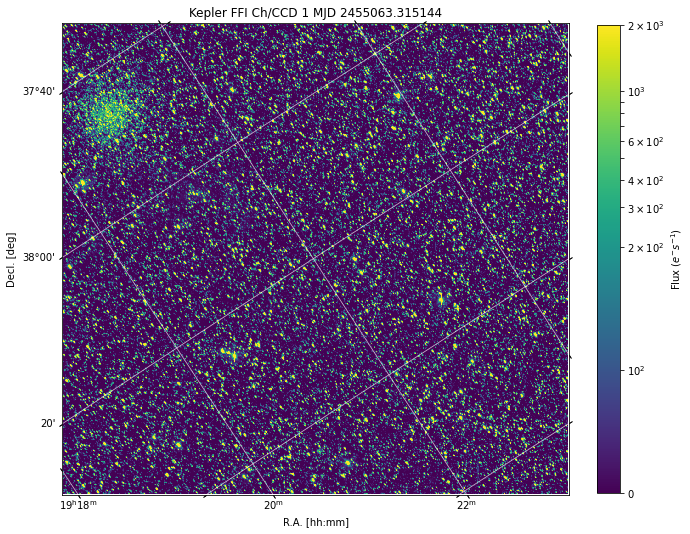

In [45]:
ffi.plot_image(sources=False);

The mask with rejected pixels can be visualized with `self.plot_pixel_mask()`. Here, yellow patches are pixels masked bright stars that produce halos, 
while red markers are saturated pixels.

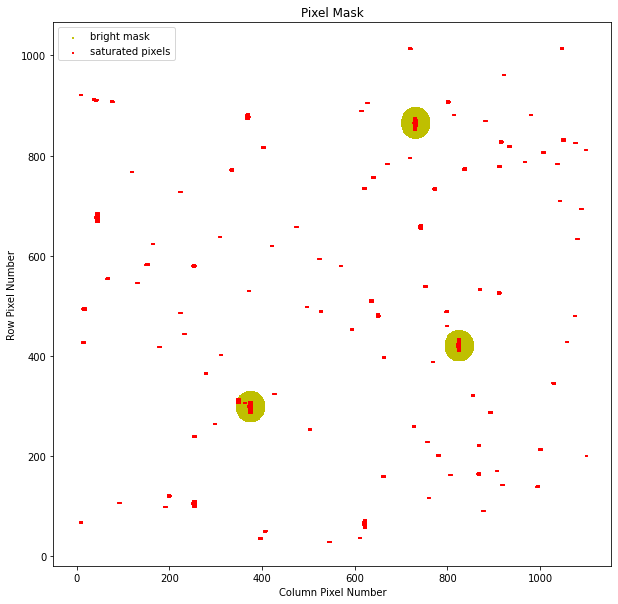

In [48]:
_ = ffi.plot_pixel_masks()

### PSF model

Let's now fit a PSF model to using all the sources in the scene. This is done using `self.build_shape_model()` and can show a diagnostic plot
with the pixel data and model in both Cartesian and Polar coordinates

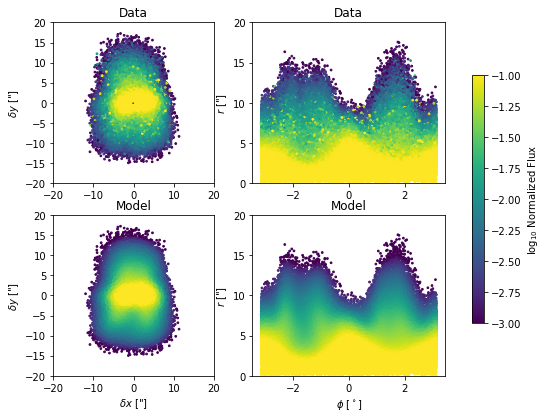

In [49]:
ffi.build_shape_model(plot=True);

Such a funky looking PSF, this is because channel 1 is at one of the edges of Kepler's focal plane where distortions are larger.

This awesome PSF model can be saved to disk (in FITS format) to be used later by `PSFMachine` to do PSF photometry 
on Kepler's TPFs instead of using the low number of sources and pixels that the TPFs have.
We save the model with `self.save_shape_model()`, by default it is saved in the working directory with a name 
that describe the data we use. It also accepts custom names with the `output` parameter.

In [50]:
ffi.save_shape_model()

We can check the new file

In [56]:
!ls -lh *.fits

-rw-r--r--  1 jorgemarpa  staff   8.4K Nov  5 21:08 Kepler_ffi_shape_model_ext1_q2.fits


In [57]:
!fitsheader Kepler_ffi_shape_model_ext1_q2.fits

# HDU 0 in Kepler_ffi_shape_model_ext1_q2.fits:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CHECKSUM= 'B7fDE7ZAB7dAB7ZA'   / HDU checksum updated 2021-11-05T21:08:05       
DATASUM = '0       '           / data unit checksum updated 2021-11-05T21:08:05 

# HDU 1 in Kepler_ffi_shape_model_ext1_q2.fits:
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                  169 / length of dimension 2                          
PCOUNT  =   

Let's check that the model was saved correctly by loading it with `self.load_shape_model()` we can plot the diagnostic figure to double check it looks OK.

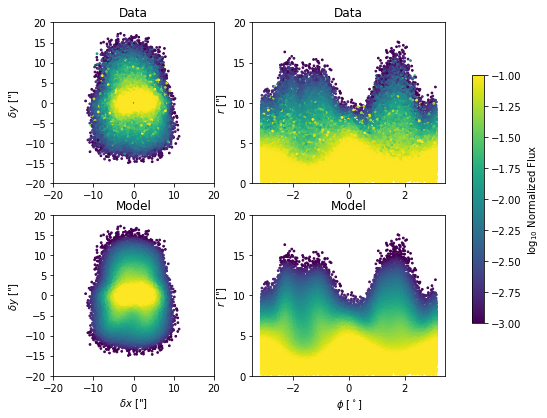

In [58]:
# this might take some time to run
ffi.load_shape_model(input="./Kepler_ffi_shape_model_ext1_q2.fits", plot=True);

Awesome! we recover our nice PSF model.

### Do PSF photometry

Also we can get PSF photometry of every source with `self.fit_model(fit_va=False)`, here we set the `fit_va` parameter to `False`,
because we are working with just one cadence, even if loading multiple FFI epochs, fitting a time model like in `PSFMachine` doesn't make
sense due to the sparse observations. The photometry is stored in the `self.ws` and `self.werrs` attributes.

The source catalog can be saved to a FITS file with `self.save_flux_values()` that has the `output` parameter for custom file names, 
by default the file is saved in the working directory.
This function internally runs `self.fit_model(fit_va=False)`, so no need to do both here.

In [32]:
# this will take lot of time if working with a full channel FFI
ffi.save_flux_values()

File name:  ./Kepler_source_catalog_ext1_q2_mjd2455063.31514402.fits


## K2 FFI

`FFIMachine` also supports K2 FFIs.
Let's see how this work!

This time lets take a cutout of channel 43.

In [64]:
file_path = "/Users/jorgemarpa/Work/BAERI/ADAP/data"
fname = f"{file_path}/k2/ffi/ktwo2014070234206-c00_ffi-cal.fits"

In [67]:
k2ffi = pm.FFIMachine.from_file(fname, extension=43, cutout_size=300, cutout_origin=[600, 600])
k2ffi

Creating delta arrays: 100%|█████████████████████████████████████████████████████| 1339/1339 [00:02<00:00, 545.87it/s]


FFIMachine (N sources, N times, N pixels): (1339, 1, 83714)

This time the object initialization was much faster, we are just loading 300 x 300 pixels.

We can check the some meta data 

In [68]:
k2ffi.meta

{'TELESCOP': 'Kepler',
 'INSTRUME': 'Kepler Photometer',
 'MISSION': 'K2',
 'DATSETNM': 'ktwo2014070234206-c00',
 'RADESYS': 'ICRS',
 'EQUINOX': 2000.0,
 'BACKAPP': False,
 'EXTENSION': 43,
 'QUARTER': 0,
 'DCT_TYPE': 'FFI'}

A visualization of the image, this time marking the sources with red circles

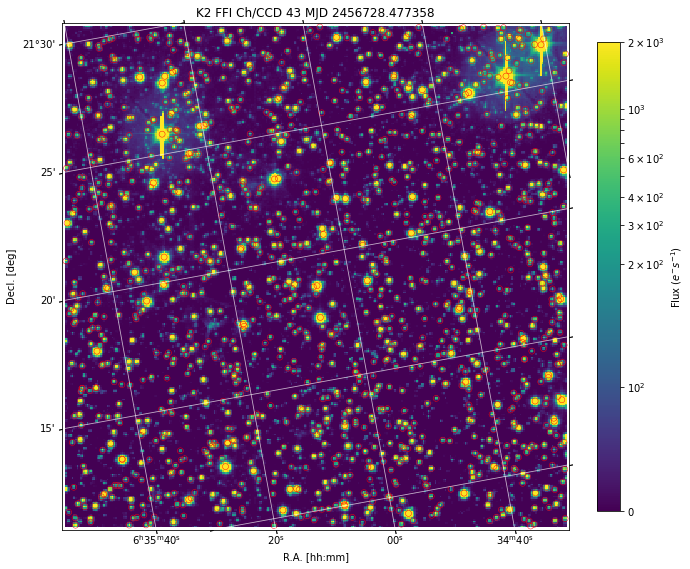

In [69]:
_ = k2ffi.plot_image(sources=True)

We build a shape model again

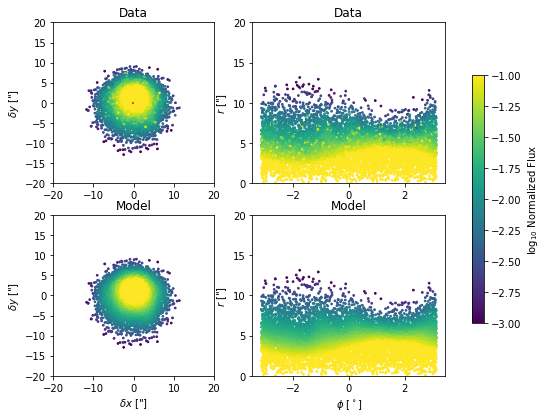

In [70]:
_ = k2ffi.build_shape_model(plot=True)

This PSF model is more rounded because channel 43 is in the center of Kepler's focal plane.

Lets save the photometry to disk and see how the FITS file looks like:

In [71]:
k2ffi.save_flux_values()

Fitting 1339 Sources (No VA): 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


In [72]:
!ls -lh *.fits

-rw-r--r--  1 jorgemarpa  staff    87K Nov  5 21:25 K2_source_catalog_ext43_q0_mjd2456728.47735842.fits
-rw-r--r--  1 jorgemarpa  staff   8.4K Nov  5 21:08 Kepler_ffi_shape_model_ext1_q2.fits


In [73]:
!fitsheader K2_source_catalog_ext43_q0_mjd2456728.47735842.fits

# HDU 0 in K2_source_catalog_ext43_q0_mjd2456728.47735842.fits:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'Photometric Catalog' / Photometry                                    
ORIGIN  = 'PSFmachine.FFIMachine' / Software of origin                          
VERSION = '1.1.0   '           / Software version                               
TELESCOP= 'Kepler  '           / Telescope                                      
MISSION = 'K2      '           / Mission name                                   
DCT_TYPE= 'FFI     '           / Data type                                      
QUARTER =                    0 / Quarter/Campaign/Sector of observations        
CHANNEL =                   43 / Channel/Came

In [79]:
table = Table.read("K2_source_catalog_ext43_q0_mjd2456728.47735842.fits")
table

gaia_id,ra,dec,psf_flux,psf_flux_err
,deg,deg,-e/s,-e/s
bytes29,float64,float64,float64,float64
Gaia EDR3 3373071429411856000,98.65870854646455,21.136655773508906,1603.8494957238856,72.0554024396905
...,...,...,...,...
Gaia EDR3 3373119498684323456,98.84477190034355,21.492906885836497,5546.36463348531,106.1639293048
